# Developing the Model Architecture

This is a notebook for the development of a PyTorch implementation of Log-Additive Convolutional Neural Networks in Pytorch, following the model architecture described in [*A log-additive neural model for spatio-temporal prediction of groundwater levels*](https://doi.org/10.1016/j.spasta.2023.100740) by Pagendam et. al. 

## Model Diagram from Pagendam et. al.:

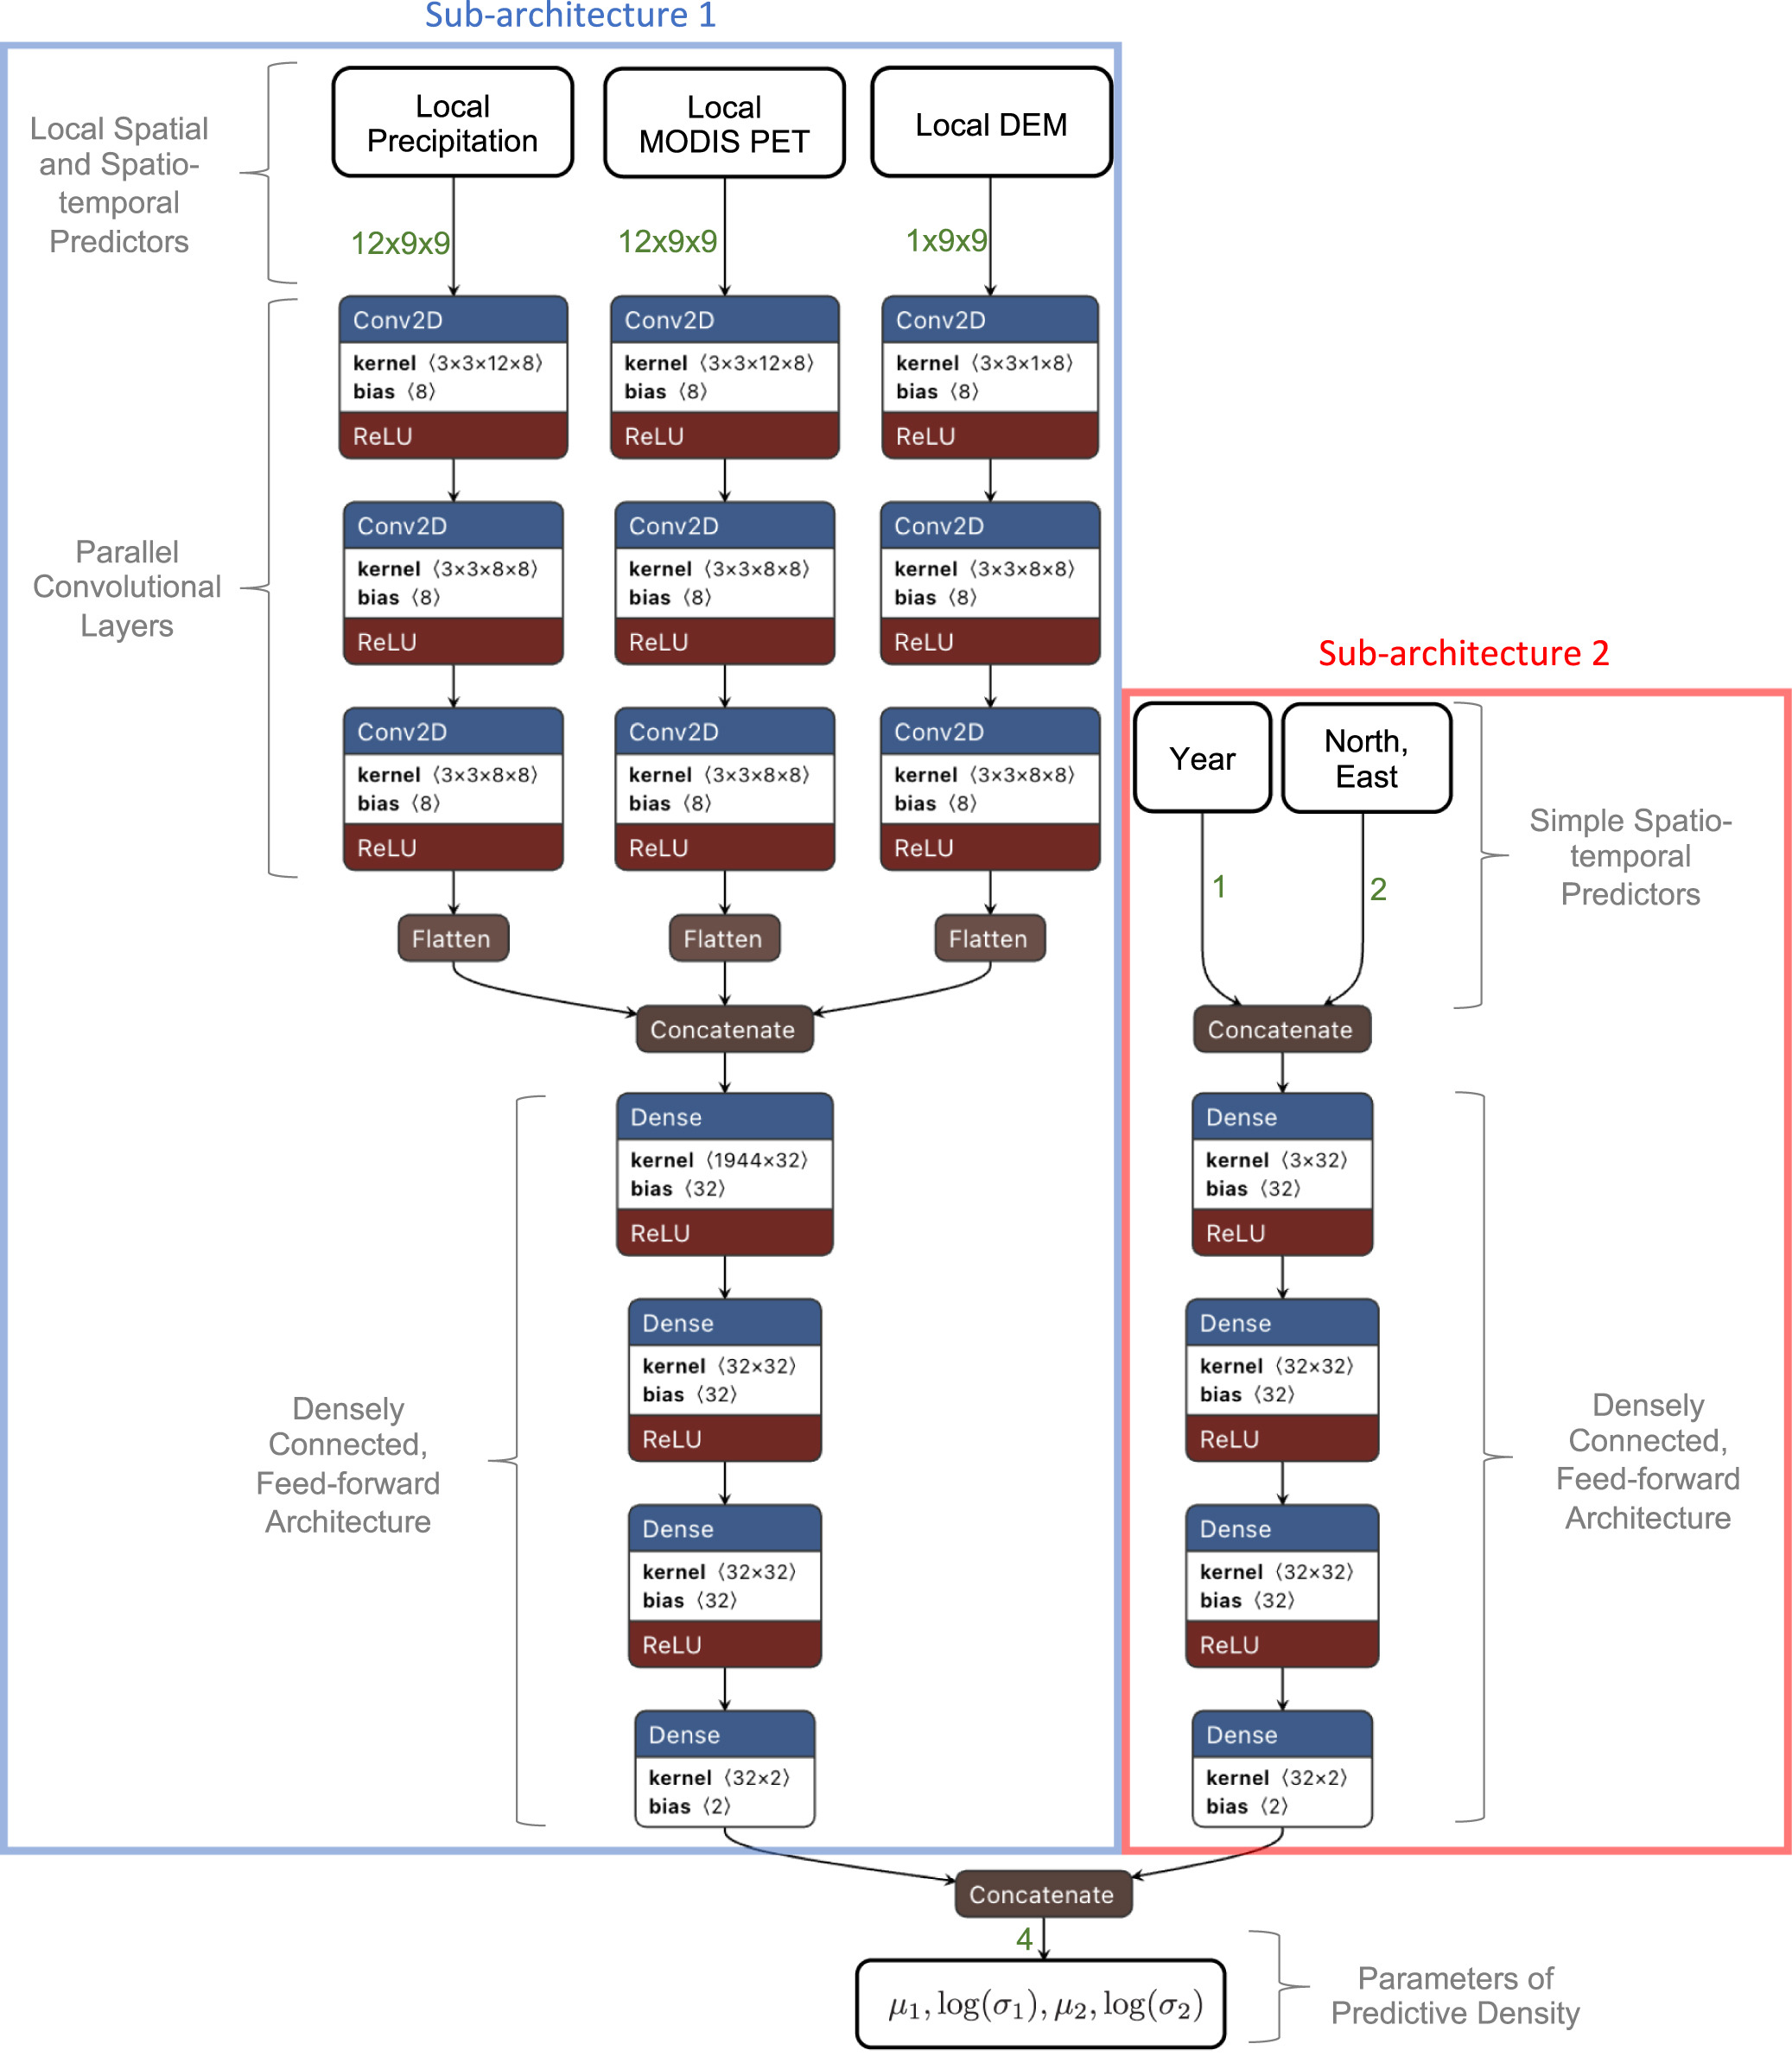

This is the convolutional-based architecture described in the paper, which performs better than the convolutional-LSTM model they also tried.

An interesting note from the paper about their convolutional-based architecture is:

> [...] we did not see improved performance when using batch normal- isation (Ioffe and Szegedy, 2015; Santurkar et al., 2018) or pooling layers (LeCunn et al., 1989, 1998; Ranzato et al., 2007) after the convolutional layers.

## Implementing it in PyTorch

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn

In [2]:
def count_tokens(w, h, k, s, p):
    """ Function to count how many tokens are produced from a given soft split

        Args:
            w (int): starting width
            h (int): starting height
            k (int): kernel size
            s (int): stride size
            p (int): padding size

        Returns:
            new_w (int): number of tokens along the width
            new_h (int): number of tokens along the height
            total (int): total number of tokens created

        See Also: 
        Formula taken from 
        https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html#torch.nn.Unfold
        Assuming a 2D input, dilation = 1, and symmetric padding, kernel, and stride
    """

    new_w = int(math.floor(((w + 2*p - (k-1) -1)/s)+1))
    new_h = int(math.floor(((h + 2*p - (k-1) -1)/s)+1))
    total = new_w * new_h

    return new_w, new_h, total

In [3]:
class Local_Effects(nn.Module):
    def __init__(self,
                 in_chan: int=12,
                 kernel: int=3,
                 neurons: int=8,
                 bias: bool=True,
                 activation = nn.ReLU,
                 depth: int=3):
        
        super().__init__()

        ## Define Paramaters
        self.in_chan = in_chan #number of input channels
        self.kernel = kernel #size of square convolutional kernel
        self.neurons = neurons #number of neurons/features/channels
        self.bias = bias #if the convolutions estimate bias
        self.depth = depth #how many sets of Conv2d/Activation there are
        assert self.depth >= 1, 'Depth must be equal to or greater than 1.'
        
        ## Define Layers
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(nn.Conv2d(self.in_chan, self.neurons, self.kernel, bias=self.bias, padding='same'))
        for i in range(1, self.depth):
            self.conv_layers.append(nn.Conv2d(self.neurons, self.neurons, self.kernel, bias=self.bias, padding='same'))

        self.act_layers = nn.ModuleList()
        for i in range(self.depth):
            self.act_layers.append(activation())
    
    def forward(self, x):
        for i in range(self.depth):
            x = self.conv_layers[i](x)
            x = self.act_layers[i](x)

        x = torch.flatten(x, start_dim=1)
        return(x)


In [4]:
x = torch.rand(13, 12, 9, 9)
local_test = Local_Effects(in_chan = 12,
                             kernel = 3,
                             neurons = 8,
                             bias = True,
                             activation = nn.ReLU,
                             depth = 3)
output = local_test(x)
output.shape

torch.Size([13, 648])

In [5]:
class Sub1(nn.Module):
    def __init__(self, 
                 local_effects_kernel: int=3,
                 local_effects_neurons: int=8,
                 local_effects_bias: bool=True,
                 local_effects_depth: int=3,
                 activation = nn.ReLU,
                 dense_neurons: int=32,
                 dense_bias: bool=True,
                 dense_depth: int = 4):

        super().__init__()
    
        ## Define Parameters
        self.dense_neurons = dense_neurons
        self.dense_bias = dense_bias
        self.dense_depth = dense_depth
        assert self.dense_depth >= 1, 'Dense Depth must be equal to or greater than 1.'
        self.concat_len = 9 * 9 * local_effects_neurons * 3 #9x9 image, times number of neurons, times 3 branches
        
        ## Define Layers
        self.precipitation_branch = Local_Effects(in_chan = 12,
                                                 kernel = local_effects_kernel,
                                                 neurons = local_effects_neurons,
                                                 bias = local_effects_bias,
                                                 activation = activation,
                                                 depth = local_effects_depth)
        self.modis_branch = Local_Effects(in_chan = 12,
                                         kernel = local_effects_kernel,
                                         neurons = local_effects_neurons,
                                         bias = local_effects_bias,
                                         activation = activation,
                                         depth = local_effects_depth)
        self.dem_branch = Local_Effects(in_chan = 1,
                                         kernel = local_effects_kernel,
                                         neurons = local_effects_neurons,
                                         bias = local_effects_bias,
                                         activation = activation,
                                         depth = local_effects_depth)
        
        self.dense_layers = nn.ModuleList()
        self.dense_layers.append(nn.Linear(self.concat_len, self.dense_neurons, bias=self.dense_bias))
        for i in range(1, self.dense_depth-1):
            self.dense_layers.append(nn.Linear(self.dense_neurons, self.dense_neurons, bias=self.dense_bias))
        self.dense_layers.append(nn.Linear(self.dense_neurons, 2, bias=self.dense_bias))
        
        self.act_layers = nn.ModuleList()
        for i in range(self.dense_depth-1):
            self.act_layers.append(activation())

    def forward(self, precipitation, modis, dem):
        precipitation = self.precipitation_branch(precipitation)
        modis = self.modis_branch(modis)
        dem = self.dem_branch(dem)
        x = torch.cat((precipitation, modis, dem), dim=1)

        for i in range(self.dense_depth-1):
            x = self.dense_layers[i](x)
            x = self.act_layers[i](x)
        x = self.dense_layers[i+1](x)
        return(x)

In [6]:
xp = torch.rand(13, 12, 9, 9)
xm = torch.rand(13, 12, 9, 9)
xd = torch.rand(13, 1, 9, 9)
sub1_test = Sub1(local_effects_kernel=3,
                 local_effects_neurons=8,
                 local_effects_bias=True,
                 local_effects_depth=3,
                 activation=nn.ReLU,
                 dense_neurons=32,
                 dense_bias=True,
                 dense_depth=4)
output = sub1_test(xp, xm, xd)
output.shape

torch.Size([13, 2])

In [7]:
class Sub2(nn.Module):
    def __init__(self, 
                 activation = nn.ReLU,
                 dense_neurons: int=32,
                 dense_bias: bool=True,
                 dense_depth: int = 4):

        super().__init__()
    
        ## Define Parameters
        self.dense_neurons = dense_neurons
        self.dense_bias = dense_bias
        self.dense_depth = dense_depth
        assert self.dense_depth >= 1, 'Dense Depth must be equal to or greater than 1.'

        ## Define Layers
        self.dense_layers = nn.ModuleList()
        self.dense_layers.append(nn.Linear(3, self.dense_neurons, bias=self.dense_bias))
        for i in range(1, self.dense_depth-1):
            self.dense_layers.append(nn.Linear(self.dense_neurons, self.dense_neurons, bias=self.dense_bias))
        self.dense_layers.append(nn.Linear(self.dense_neurons, 2, bias=self.dense_bias))

        self.act_layers = nn.ModuleList()
        for i in range(self.dense_depth-1):
            self.act_layers.append(activation())

    def forward(self, year, coords):
        x = torch.cat((year, coords), dim=1)

        for i in range(self.dense_depth-1):
            x = self.dense_layers[i](x)
            x = self.act_layers[i](x)
        x = self.dense_layers[i+1](x)
        return(x)

In [8]:
xy = torch.rand(13, 1)
xc = torch.rand(13, 2)
sub2_test = Sub2(activation=nn.ReLU,
                 dense_neurons=32,
                 dense_bias=True,
                 dense_depth=4)
output = sub2_test(xy, xc)
output.shape

torch.Size([13, 2])

In [9]:
class CNN(nn.Module):
    def __init__(self, 
                 local_effects_kernel: int=3,
                 local_effects_neurons: int=8,
                 local_effects_bias: bool=True,
                 local_effects_depth: int=3,
                 activation = nn.ReLU,
                 dense_neurons: int=32,
                 dense_bias: bool=True,
                 dense_depth: int = 4):
        
        super().__init__()
        
        self.sub1 = Sub1(local_effects_kernel = local_effects_kernel,
                         local_effects_neurons = local_effects_neurons,
                         local_effects_bias = local_effects_bias,
                         local_effects_depth =  local_effects_depth,
                         activation = activation,
                         dense_neurons = dense_neurons,
                         dense_bias = dense_bias,
                         dense_depth = dense_depth)
        self.sub2 = Sub2(activation = activation,
                         dense_neurons = dense_neurons,
                         dense_bias = dense_bias,
                         dense_depth = dense_depth)

    def forward(self, precipitation, modis, dem, year, coords):
        sub1 = self.sub1(precipitation, modis, dem)
        sub2 = self.sub2(year, coords)
        x = torch.cat((sub1, sub2), dim=1)
        return(x)

In [10]:
xp = torch.rand(13, 12, 9, 9)
xm = torch.rand(13, 12, 9, 9)
xd = torch.rand(13, 1, 9, 9)
xy = torch.rand(13, 1)
xc = torch.rand(13, 2)
CNN_test = CNN(local_effects_kernel=3,
                 local_effects_neurons=8,
                 local_effects_bias=True,
                 local_effects_depth=3,
                 activation=nn.ReLU,
                 dense_neurons=32,
                 dense_bias=True,
                 dense_depth=4)
output = CNN_test(xp, xm, xd,  xy, xc)
output.shape

torch.Size([13, 4])